In [62]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [63]:
class SimulateMuonLifetime(object):
    """
    Class which is capable of computing and retuning simulated lifetimes of muon.
    Method of lifetime simulation uses the box method with a triangular and square 
    shape.
    """

    def __init__(self, muLifetimeTruth, distributionLimits=(0, 10)):
        #=======================================================================
        # Class constructor. Distribution limits are in units of microseconds 
    
        # Define the inverse lifetime for easier computations
        self.muLifetimeTruth = muLifetimeTruth            
        self.lowLimit, self.highLimit = distributionLimits
        self.randomLifetimesList = []
        self.randomLifetimesArray = np.array([])

    def exponantialTruth(self, x, lifetime):
        #=======================================================================
        # Return output of exponential finction using specified decay rate

        return (1/lifetime)*np.exp(-x/lifetime)
    
    def sampleSingleRandomLifetime(self,):
        #=======================================================================
        # Simulate the lifetime of a single muon 
        
        return np.random.exponential(self.muLifetimeTruth)
    
    def wipeRandomLifetimeList(self,):
        #=======================================================================
        # Remove entries from random lifetime list

        self.randomLifetimesList = []

    def sampleLifetimes(self, numSamples):
        #=======================================================================
        # Return an array containing all the desired randomised muon lifetimes

        if len(self.randomLifetimesList) != 0:
            raise Exception("self.randomLifetimeList is not empty. Wipe entries before inititing a new simulation")

        # iterate over all desired simulation points
        while True:
            randomLifetimeCanditade = self.sampleSingleRandomLifetime()
            # Check if generated muon lifetime is within the desired bounds
            if (self.lowLimit < randomLifetimeCanditade) and (randomLifetimeCanditade<self.highLimit):
                self.randomLifetimesList.append(randomLifetimeCanditade)
            
            if len(self.randomLifetimesList) >= numSamples:
                # Create object containing simulated lifetime of muons
                self.randomLifetimesArray = np.array(self.randomLifetimesList)
                # Wipe data from estimated lifetime list for a subsequent simulation
                self.wipeRandomLifetimeList()
                break

        return self.randomLifetimesArray
    
    def computeEstimatedLifetime(self,):
        #=======================================================================
        # Compute the overall simulated lifetime of a muon using simulated 
        # As muon lifetime is drawn from an exponential PDF, decay rate is computed by computing
        # average value        

        if (self.randomLifetimesArray.size == 0):
            raise Exception("The random lifetims array has not been initialised.")

        return self.randomLifetimesArray.mean()

    def simulateMultipleMuonLifetimes(self, numSamples, numSimulations):
        #=======================================================================
        # Run full simulation chain fro specified number of simulations and return
        # array containing results
        
        simulatedLifetimeList = []
        
        # Iterate over simulation chain for  desired events
        for _ in range(numSimulations):
            _ = self.sampleLifetimes(numSamples)
            simulatedLifetimeList.append(self.computeEstimatedLifetime())
        
        return np.array(simulatedLifetimeList)

In [64]:
def runSimulation():
    """
    Parameters
    """
    MU_LIFETIME_TRUTH = 2.2         # in microseconds
    NUM_SAMPLES = 1000
    NUM_SIMULATIONS = 500
    LIMITS_1 = (0, 10)
    LIMITS_2 = (0, 5)
    LIMITS_3 = (0, 20)
    TIME = np.linspace(*LIMITS_1, 1000)

    # Initualise simulatuon class
    muonSimulation = SimulateMuonLifetime(MU_LIFETIME_TRUTH, LIMITS_1)

    # Get 1000 random ramples of muon lifetime
    sampledMuonLifetimes = muonSimulation.sampleLifetimes(NUM_SAMPLES)
    print(f"The simulated average muon lifetime with range 0 < t < 10 is {muonSimulation.computeEstimatedLifetime():.3f} mu s")

    # Plot distribution of sampled lifetimes with predicted distribution
    plt.hist(sampledMuonLifetimes, bins=100, density=True, label="Sampled distribution")
    plt.plot(TIME, muonSimulation.exponantialTruth(TIME, MU_LIFETIME_TRUTH),label="Predicted distribution") 
    plt.xlabel("Muon Lifetime, t ($\mu s$)")
    plt.ylabel("Probability")
    plt.xlim(LIMITS_1)
    plt.title("Distribution of randomly sampled muon lifetimes")
    plt.legend()
    # plt.savefig("figures/sampled_distribution.png")
    figure1 = plt.gcf()
    plt.show()
    
    """
    Simulate multiple average muon lifetime
    """

    # Initialise other muon simulation classes with different limits
    muonSimulationLowLimits = SimulateMuonLifetime(MU_LIFETIME_TRUTH, LIMITS_2)
    muonSimulationHighLimits = SimulateMuonLifetime(MU_LIFETIME_TRUTH, LIMITS_3)
    
    simulatedLifetimesNormalLimits = muonSimulation.simulateMultipleMuonLifetimes(
        NUM_SAMPLES, 
        NUM_SIMULATIONS
    )
    simulatedLifetimesLowLimits = muonSimulationLowLimits.simulateMultipleMuonLifetimes(
        NUM_SAMPLES, 
        NUM_SIMULATIONS
    )
    simulatedLifetimesHighLimits = muonSimulationHighLimits.simulateMultipleMuonLifetimes(
        NUM_SAMPLES, 
        NUM_SIMULATIONS
    )

    # Place all simulated datasets in a list to allow for them to be looped over

    overallSimulatedDataset = [
        simulatedLifetimesNormalLimits,
        simulatedLifetimesLowLimits,
        simulatedLifetimesHighLimits
    ]

    overallLabels = [
        f"limits: {LIMITS_1[0]} < t < {LIMITS_1[1]}",
        f"limits: {LIMITS_2[0]} < t < {LIMITS_2[1]}",
        f"limits: {LIMITS_3[0]} < t < {LIMITS_3[1]}",
    ]

    yMax = 0        # Initialising variable for use in loop    
    
    # Plot histogram of simulated muon lifetimes with different limits
    for i in range(len(overallSimulatedDataset)):
        binHights, _, _ = plt.hist(overallSimulatedDataset[i], bins=50, label=overallLabels[i])
        currentYMax = binHights.max()
        yMax = currentYMax if (yMax < currentYMax) else yMax

    
    plt.xlabel("Simulated muon lifetimes, t ($\mu s$)")
    plt.ylabel("Counts")
    plt.title("Histogram of simulated muon lifetimes")
    plt.vlines(MU_LIFETIME_TRUTH, 0, yMax, colors="k", linestyles="dashed", label="True muon lifetime")
    
    # Plot vertical lines at the simulated lifetimes for each histogram in the plot
    for i in range(len(overallSimulatedDataset)):    
        plt.vlines(
            overallSimulatedDataset[i].mean(), 0, yMax, colors="m",
            linestyles="dashed", label= "Simulated Lifetime" if i==0 else None,
        )
    
    plt.legend()
    # plt.savefig("figures/simulated_distribution.png")
    figure2 = plt.gcf()
    plt.show() 

    return (figure1, figure2)

In [65]:
%%capture
figure1, figure2 = runSimulation()

# Week 3 Checkpoint

### Discussion on results

If we look at the frist figure, representing a histogram of the 1000 randomly sampled muon lifetimes, we note that the lifetimes were sampled within a finite range (in the case of this distribution, the limits are within $t_{\mu} \in [0, 10]$). This will result in there being a systematic undercounting of the muon lifetimes when we randomly sample from our defined exponential distribution. This is the source of the primary bias in our simulation.

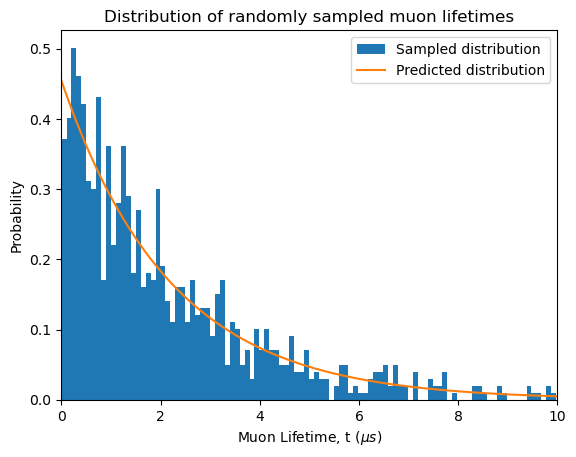

In [66]:
figure1

By increaing the upper bound of our limits from which we are sampling the muon lifetimes, we will get reduce the sistematic error in our bias and will get distribution of simulated lifetimes which are closer to the truth muon lifetime. The oposit is also true, hence by reducing the upper bounds of the limit, we will increase our bias and get a larger systematic error. This can be seen in the second figure seen below.


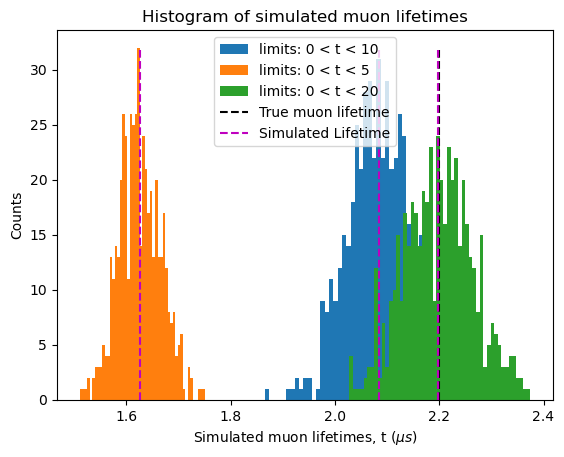

In [67]:
figure2

The precision of a single simulated muon lifetime is primarily limited by the standard error of the mean, which is given by $E_{mean} = \frac{\sigma}{\sqrt{N}}$ where N is the umber of samples used to compute the mean. This means that our precision is dependent on how many random samples we take from the exponential distribution.